<a href="https://colab.research.google.com/github/aravind2060/100-days-of-machine-learning/blob/main/Neural_Network_Training_Loop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Neural Network Lab

Professor: Rick Chakra

TA: Rebecca Jones

#Let's build a Neural Network

The first step is to import pytorch and make sure its the right version!

In [1]:
# Import Pytorch
import torch
print(torch.__version__)

2.6.0+cu124


In [2]:
#If it wont import because torch isn't installed
#!pip install torch

Lets now import the other packages we need

In [3]:
# Import other packages
from numpy import vstack
from pandas import read_csv
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch import Tensor
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Sigmoid
from torch.nn import Module
from torch.optim import SGD
from torch.nn import BCELoss
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_
from matplotlib import pyplot as plt

After importing the remaining packages needed to make a Nural Network we need to set up our dataset to be used by pytorch.

In [4]:
# Difine Dataset
class CSVDataset(Dataset):
    # load the dataset
    def __init__(self, path):
        # load the csv file as a dataframe
        self.df = read_csv(path, header=0)
        # store the inputs and outputs
        self.X = self.df.values[:, :-1]
        self.y = self.df.values[:, -1]
        # ensure input data is floats
        self.X = self.X.astype('float32')
        # label encode target and ensure the values are floats
        self.y = LabelEncoder().fit_transform(self.y)
        self.y = self.y.astype('float32')
        self.y = self.y.reshape((len(self.y), 1))

    # number of rows in the dataset
    def __len__(self):
        return len(self.X)

    # get a row at an index
    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]

    # get indexes for train and test rows
    def get_splits(self, n_test=0.2,n_val=0.2):
        # determine sizes
        test_size = round(n_test * len(self.X))
        val_size = round(n_val * len(self.X))
        train_size = len(self.X) - test_size - val_size
        # calculate the split
        return random_split(self, [train_size, test_size, val_size])

    # get dataset
    def get_dataset(self):
      return self.df

Next we are going to make a function to use the previous function and split our dataset.

In [5]:
# prepare the dataset
def prepare_data(path):
    # load the dataset
    dataset = CSVDataset(path)
    # calculate split
    train, test, val = dataset.get_splits()
    # prepare data loaders
    train_dl = DataLoader(train, batch_size=47, shuffle=True)
    val_dl = DataLoader(val, batch_size=47, shuffle=True)
    test_dl = DataLoader(test, batch_size=116, shuffle=False)

    # get df
    df = dataset.get_dataset()
    return df, train_dl, test_dl, val_dl

Now that we have all of our data functions defined we can call them to prepare our data

In [6]:
#Import and prepare the data
path = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/ionosphere.csv'
# path = 'ionosphere.csv'
df, train_dl, test_dl, val_dl = prepare_data(path)
print(len(train_dl.dataset), len(test_dl.dataset), len(val_dl.dataset))

210 70 70


In [7]:
# view dataset
print(df)

     1  0  0.99539  -0.05889  0.85243  0.02306  0.83398  -0.37708      1.1  \
0    1  0  1.00000  -0.18829  0.93035 -0.36156 -0.10868  -0.93597  1.00000   
1    1  0  1.00000  -0.03365  1.00000  0.00485  1.00000  -0.12062  0.88965   
2    1  0  1.00000  -0.45161  1.00000  1.00000  0.71216  -1.00000  0.00000   
3    1  0  1.00000  -0.02401  0.94140  0.06531  0.92106  -0.23255  0.77152   
4    1  0  0.02337  -0.00592 -0.09924 -0.11949 -0.00763  -0.11824  0.14706   
..  .. ..      ...       ...      ...      ...      ...       ...      ...   
345  1  0  0.83508   0.08298  0.73739 -0.14706  0.84349  -0.05567  0.90441   
346  1  0  0.95113   0.00419  0.95183 -0.02723  0.93438  -0.01920  0.94590   
347  1  0  0.94701  -0.00034  0.93207 -0.03227  0.95177  -0.03431  0.95584   
348  1  0  0.90608  -0.01657  0.98122 -0.01989  0.95691  -0.03646  0.85746   
349  1  0  0.84710   0.13533  0.73638 -0.06151  0.87873   0.08260  0.88928   

     0.03760  ...  -0.51171  0.41078  -0.46168  0.21266  -0.340

Now that our data is ready we need to make our model. Unlike the other model types we have used in this class, we need to actually make our model (This can involve a lot of tuning in real life). For this example lets make 3 hidden layers.

In [8]:
# model definition
class MLP(Module):
    # define model elements
    def __init__(self, n_inputs):
        super(MLP, self).__init__()
        # input to first hidden layer
        self.hidden1 = Linear(n_inputs, 10)
        kaiming_uniform_(self.hidden1.weight, nonlinearity='relu')
        self.act1 = ReLU()
        # second hidden layer
        self.hidden2 = Linear(10, 8)
        kaiming_uniform_(self.hidden2.weight, nonlinearity='relu')
        self.act2 = ReLU()
        # third hidden layer and output
        self.hidden3 = Linear(8, 1)
        xavier_uniform_(self.hidden3.weight)
        self.act3 = Sigmoid()

    # forward propagate input
    def forward(self, X):
        # input to first hidden layer
        X = self.hidden1(X)
        X = self.act1(X)
         # second hidden layer
        X = self.hidden2(X)
        X = self.act2(X)
        # third hidden layer and output
        X = self.hidden3(X)
        X = self.act3(X)
        return X

Now we need to choose how our model will train and improve

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

def train_model(train_dl, val_dl, model):
    criterion = nn.BCELoss()  # Binary Cross Entropy Loss for binary classification
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    train_losses = []
    val_losses = []

    for epoch in range(200):
        train_loss = 0.0
        val_loss = 0.0

        # Training phase
        model.train()  # Set model to training mode
        for i, (inputs, targets) in enumerate(train_dl):
            optimizer.zero_grad()  # Zero out the gradients to prevent accumulation from previous iterations
            yhat = model(inputs)  # Forward pass through the model
            loss = criterion(yhat, targets)  # Calculate loss using yhat vs targets in criterion
            loss.backward()  # Backpropagate the gradients
            optimizer.step()  # Update the model parameters based on gradients
            train_loss += loss.item()  # Accumulate the training loss

        # Validation phase
        model.eval()  # Set model to evaluation mode
        with torch.no_grad():  # Disable gradient calculation for validation to save memory and computation
            for inputs, targets in val_dl:
                yhat = model(inputs)  # Forward pass through the model
                loss = criterion(yhat, targets)  # Calculate loss using yhat vs targets in criterion
                val_loss += loss.item()  # Accumulate the validation loss

        # Average loss for the epoch
        train_loss /= len(train_dl)
        val_loss /= len(val_dl)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f'Epoch [{epoch + 1}/200], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    # Plotting the training and validation losses
    plt.plot(range(1, 201), train_losses, label='Train')
    plt.plot(range(1, 201), val_losses, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.show()

Now we set up a function to define how to evaluate the model (accuracy)

In [13]:
# evaluate the model
def evaluate_model(test_dl, model):
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_dl):
        # evaluate the model on the test set
        yhat = model(inputs)
        # retrieve numpy array
        yhat = yhat.detach().numpy()
        actual = targets.numpy()
        actual = actual.reshape((len(actual), 1))
        # round to class values
        yhat = yhat.round()
        # store
        predictions.append(yhat)
        actuals.append(actual)
    predictions, actuals = vstack(predictions), vstack(actuals)
    # calculate accuracy
    acc = accuracy_score(actuals, predictions)
    return acc

To further show how our model is working lets have the completed model create a prediction on a row of data

In [14]:
# make a class prediction for one row of data
def predict(row, model):
    # Convert row to a tensor
    row = torch.tensor([row], dtype=torch.float32)  # Ensure proper dtype for model input

    # Make prediction by passing data through the model
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation during prediction
        yhat = model(row)  # Pass the row through the model

    # Retrieve NumPy array from the output tensor
    yhat = yhat.detach().numpy()  # Convert tensor to NumPy array

    return yhat

Now its time to actually run the model and have it use our data!

Epoch [1/200], Train Loss: 0.6494, Val Loss: 0.5849
Epoch [2/200], Train Loss: 0.5497, Val Loss: 0.5232
Epoch [3/200], Train Loss: 0.4865, Val Loss: 0.4635
Epoch [4/200], Train Loss: 0.4609, Val Loss: 0.4714
Epoch [5/200], Train Loss: 0.4481, Val Loss: 0.5154
Epoch [6/200], Train Loss: 0.4385, Val Loss: 0.4641
Epoch [7/200], Train Loss: 0.4142, Val Loss: 0.4734
Epoch [8/200], Train Loss: 0.4084, Val Loss: 0.4550
Epoch [9/200], Train Loss: 0.3822, Val Loss: 0.4365
Epoch [10/200], Train Loss: 0.3845, Val Loss: 0.3837
Epoch [11/200], Train Loss: 0.3660, Val Loss: 0.3997
Epoch [12/200], Train Loss: 0.3363, Val Loss: 0.3826
Epoch [13/200], Train Loss: 0.3187, Val Loss: 0.3927
Epoch [14/200], Train Loss: 0.3154, Val Loss: 0.3718
Epoch [15/200], Train Loss: 0.3086, Val Loss: 0.3893
Epoch [16/200], Train Loss: 0.2953, Val Loss: 0.3586
Epoch [17/200], Train Loss: 0.2952, Val Loss: 0.3484
Epoch [18/200], Train Loss: 0.2715, Val Loss: 0.3862
Epoch [19/200], Train Loss: 0.2412, Val Loss: 0.3012
Ep

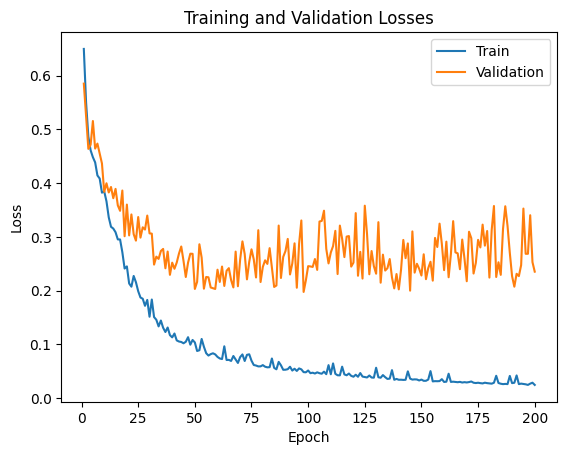

In [15]:
# Define the network
model = MLP(n_inputs=34)  # Create instance of the model with 34 input features

# Train the model
train_model(train_dl, val_dl, model)  # Train the model with the training and validation dataloaders

# Evaluate the model
acc = evaluate_model(test_dl, model)  # Evaluate the model with the test dataloader

In [16]:
# print final model accuracy
print('Final Model Accuracy: %.3f' % acc)

Final Model Accuracy: 0.986


One of the reasons that we use functions so much in this section is it allows for an easier time making different models and comparing how they preform!